# RentHop House Listing Price Prediction

The final project for DS-GA1001 Introduction to Data Science

## Package Import

In [167]:
# Python
from collections import defaultdict
# Data Analysis
import numpy as np # linear algebra
import scipy as sp
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
# I/O
import os
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Exploration and Preprocessing

Read data and look at the variables we have

In [2]:
def data_cleaning(infile):
    # Import Data
    df = pd.read_json("../data/train.json")
    print df.shape
    return df
df = data_cleaning('../data/train.json')

(49352, 15)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


## Split Training Set and Test Set

We are spliting the available data into training set and test set

In [4]:
def data_split(df):
    df_y = df[['price']]
    df_X = df.drop('price', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_split(df)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(34546, 14) (14806, 14) (34546, 1) (14806, 1)


### --------- From now on, we only use the training set for modeling and validation ---------

## Data Explorations

### Addresses

We use displayed address and see what are the most frequently listed addresses

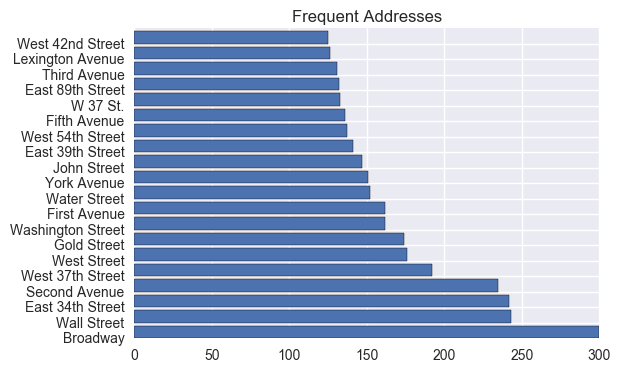

In [172]:
address_counts = X_train['display_address'].value_counts()
plt.figure()
plt.barh(range(len(address_counts))[:20],address_counts.values[:20],tick_label=address_counts.index[:20])
plt.title('Frequent Addresses')
# Most frequently used addresses
plt.show()

### Features

We filter out some features that appear multiple times (> 50) among all training samples. We make them lower cases before hand

<Container object of 79 artists>

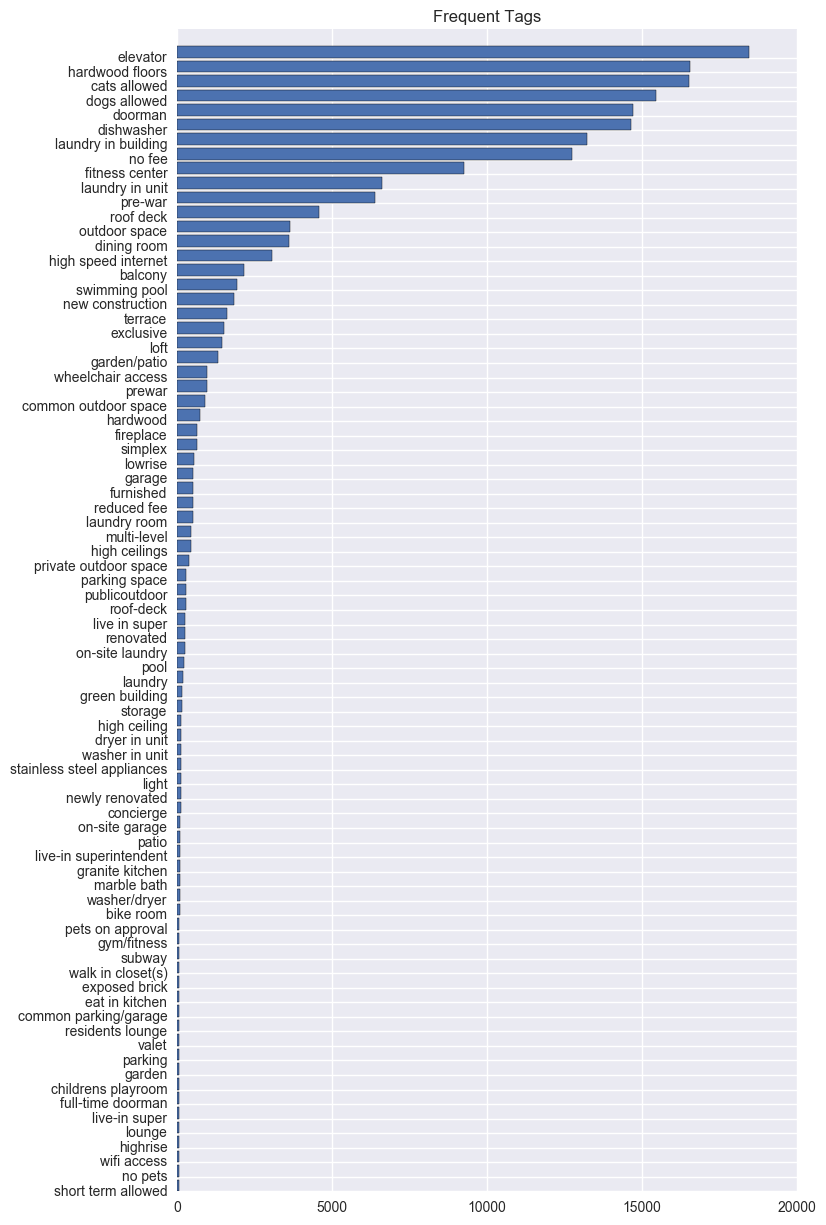

In [173]:
# Extract all features
all_features = defaultdict(int)
for f in X_train['features']:
    for i in f:
        i = i.lower() # Convert to lower cases
        all_features[i] = all_features[i] + 1
all_features_sorted = []
for kk,vv in all_features.items():
    if vv > 50: # Appear more than a certain times
        all_features_sorted.append((kk,vv))
# Take a look at the most frequently listed features
all_features_sorted = sorted(all_features_sorted, key=lambda x: x[1])
all_features_index = map(lambda x: x[0], all_features_sorted)
all_features_values = map(lambda x: x[1], all_features_sorted)
plt.figure(figsize=(8, 15))
plt.title('Frequent Tags')
plt.barh(range(len(all_features_sorted)), all_features_values,tick_label=all_features_index)

### Managers

The manager data is also interesting, listings are monitored by different managers

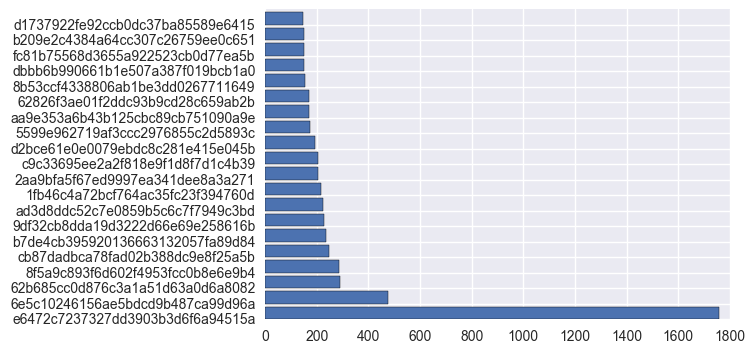

In [158]:
manager_counts = X_train['manager_id'].value_counts()
plt.figure()
plt.barh(range(len(manager_counts))[:20],manager_counts.values[:20],tick_label=manager_counts.index[:20])
# Most frequently used addresses
plt.show()

## Feature Extraction

In [114]:
def feature_extraction(data):
    # Extract the number of "photos" and "features" for each listing
    data.ix[:,'num_photos']=data.ix[:,'photos'].apply(len)
    data.ix[:,'num_features']=data.ix[:,'features'].apply(len)
    # Extract the interest level
    mm = {'low':0, 'medium':1, 'high':2}
    data.ix[:,'interest_value']=data.ix[:,'interest_level'].apply(lambda x: mm[x])
    data = data.drop('interest_level',1)
    # Extract Bag of Words for features
    
    # Extract Manager_id as categorical variables
    manager_le = OneHotEncoder()
    manager_le.fit(data['manager_id'])
    manager_leee
    return data
X_train_new = feature_extraction(X_train)
X_test_new = feature_extraction(X_test)

### Take out numeric data, transform and rescale

In [164]:
def plot_category_dist(data):
    for col in data.columns:
        if data[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            plt.figure()
            plt.hist(data[col].values)
            plt.title('Distribution of '+str(col))
            plt.show()

def data_shift(data):
    cols = ['bathrooms','bedrooms','num_photos','num_features','interest_value']
    for c in cols:
        data.ix[:,c] = np.log(data.ix[:,c])
    return data

def select_numeric_rescale(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    X_numeric = data.select_dtypes(include=numerics)
    X_numeric = X_numeric.drop('listing_id',1)
    return X_numeric
    # Log transformation
    # X_numeric = data_shift(X_numeric)
    
    # Rescale
    scaler = StandardScaler()
    X_numeric = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)
    return X_numeric
X_train_numeric = select_numeric_rescale(X_train_new)
X_test_numeric = select_numeric_rescale(X_test_new)

#### Construct X and y

In [96]:
X = X_train_numeric.values # Use numeric data as features
y = y_train.values # Target Variable: price
print X.shape, y.shape

(34546, 7) (34546, 1)


## Feature Selection

To select numeric features, we have several choices:
1. Embeded Method: We can use some linear models penalized with the L1 norm to make unimportant features has coefficient of zero.
2. Filter Method: Preprocess the features by using F-test, Correlation Matrix, etc.
3. Wrapper Method: Run model on subsets and score them

### Lasso feature selection

I've tried the recursive feature elimination method, but takes too much time, so we can instead use Lasso feature selection for the numeric data

In [160]:
# Embeded Method: Lasso 
# Reference: Wikipedia-Feature Selection

estimator = Lasso()
estimator.fit(X,y)
selector = SelectFromModel(estimator, prefit=True, threshold=0.5)
X_new = selector.transform(X)
# n_features indicates the number of features we want
n_features = X_new.shape[1]
# while n_features > 4:
#     selector.threshold += 0.1
#     X_new = selector.transform(X)
#     n_features = X_new.shape[1]
print X_new.shape
print selector.get_support() # We can see that only the first two features "bedroom", "bathroom" remains

(34546, 7)
[ True  True  True  True  True  True  True]


# Modeling

(X_new, y) is used for modeling

### Linear Regression with L1-Regularization (Lasso)

In [161]:
# Import models
ls =Lasso(alpha=0.1)
ls.fit(X_new, y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

#### Tunning alpha with Cross Validation

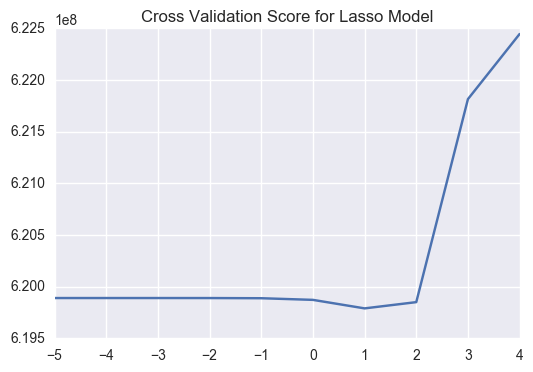

In [162]:
from sklearn.model_selection import cross_val_score
alpha_list = [10**x for x in range(-5,5)]
result = []
for i in alpha_list:
    ls = Lasso(alpha=i)
    scores = cross_val_score(ls, X_new, y, cv=10, scoring='neg_mean_squared_error')
    result.append(-np.mean(scores))
plt.figure()
plt.plot(np.log10(alpha_list), result)
plt.title('Cross Validation Score for Lasso Model')
plt.show()

In [171]:
selected_i = np.argmin(result)
ls = Lasso(alpha=alpha_list[selected_i])
ls.fit(X_train_numeric, y_train)
re = ls.predict(X_test_numeric)
print 'Test MSE: {}'.format(mean_squared_error(re, y_test))
fo = open('baseline.txt','a+')
fo.write(re)

Test MSE: 168368280.527


### Gradient Boosting

In [74]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
skf = KFold(n_splits=10)
# specify parameters via map
param = {}
num_round = 10

# Cross Validation
for train_idx, test_idx in skf.split(X_new, y):
    # print("%s %s" % (train_idx, test_idx))
    kf_X_train, kf_X_test = X_new[train_idx], X_new[test_idx]
    kf_y_train, kf_y_test = y[train_idx], y[test_idx]
    dtrain = xgb.DMatrix(kf_X_train, label=kf_y_train)
    dtest = xgb.DMatrix(kf_X_test)
    model = xgb.train(param, dtrain, num_round)
    preds = model.predict(dtest)
    print mean_squared_error(kf_y_test, preds)
# make prediction


7564072.24275
5427393.02876
1874661.78844
1320676.76008
1507760.81669
2083060073.16
330633574.711
2295168.73664
5826902360.74
1257954.53161


The performance of this model is very ugly because we haven't do any model selection and feature engineering

## Evaluation

## Deployment